In [4]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt

def ascii_data(data,zgal=1.7037455,p=False):
    wave = data[0][:]
    #zgal = 1.7037455
    wrest = wave/(1. + zgal)
    
    flx  = data[1][:]
    flx_er = data[2][:]
    # We now ignore the negative flux values in the spectrum
    q = np.where((flx > 0.)&(flx < 1e-27))
    wrest = wrest[q]
    flx  = flx[q]
    flx_er = flx_er[q]
    #### Getting the good data points only defined by the next two indices
    min_index = 8000
    max_index = 11950
    wrest = wrest[min_index:max_index]
    flx  = flx[min_index:max_index]
    flx_er = flx_er[min_index:max_index]
    '''
    if p==True:
        fig, ax = plt.subplots()
        ax.step(wrest,flx,label='Flux')
        ax.step(wrest,flx_er,label='Error')
        ax.legend(loc=0)
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Flux')
        ax.set_title('Flux Vs. Wavelength')
        plt.show()
    '''
    return wrest, flx, flx_er

### For the iron lines, I try to find the best window to work with it
def ascii_spec(wrest, flx, flx_er, minindex, maxindex): #,p=False):
    #minFeindex = 2050
    #maxFeindex = 3130
    #minMgindex = 3400
    #maxMgindex = 3950
    wrest = wrest[minindex:maxindex]
    flx  = flx[minindex:maxindex]
    flx_er = flx_er[minindex:maxindex]
    return wrest, flx, flx_er

### Doing the continuum fitting for Fe
def ascii_contn_vel(wrest,flx, flx_er,lam_center,wmin,wmax):#p=False):
    #wmin_Fe = 2580.
    #wmax_Fe = 2640.
    #wmin_Mg = 2580.
    #wmax_Mg = 2640.
    #lam_center_Fe = [2586.650,2600.173,2612.654,2626.451]
    #lam_center_Mg = [2796.351,2803.528]
    f = np.where((wrest > wmin) & (wrest < wmax))
    wrest_fit = np.delete(wrest, f)
    flx_fit = np.delete(flx,f)
    cont = np.poly1d(np.polyfit(wrest_fit, flx_fit, 3))
    continuum = cont(wrest)
    flx_norm = flx/continuum
    flx_er_norm = flx_er/continuum
    
    import musetools.util as u    
    vel = u.veldiff(wrest,lam_center)
    '''
    if p==True:
        fig1, ax1 = plt.subplots(2)
        ax1[0].step(wrest,flx,label='Flux')
        ax1[0].step(wrest,continuum,label='Continuum')
        ax1[0].step(wrest,flx_er,label='Error')
        ax1[0].legend(loc=0,fontsize='x-small')
        ax1[0].set_xlabel('Wavelength')
        ax1[0].set_ylabel('Flux')
        ax1[0].set_title('Flux Vs Wavelength')
        ax1[1].step(wrest,flx_norm,label='Relative Flux')
        ax1[1].step(wrest,flx_er_norm,label='Relative Error')
        ax1[1].legend(loc=0,fontsize='x-small')
        ax1[1].set_xlabel('Wavelength')
        ax1[1].set_ylabel('Relative Flux')
        plt.show()
        
        fig2, ax2 = plt.subplots()
        ax2.step(vel,flx_norm,label='Relative Flux')
        ax2.step(vel,flx_er_norm,label='Relative Error')
        ax2.legend(loc=0)
        ax2.set_xlabel('Velocity')
        ax2.set_ylabel('Relative Flux')
        ax2.set_title('Relative Flux Vs. Velocity')
        plt.show()
        '''
    return flx_norm, flx_er_norm, vel

import musetools.modeling as m
from lmfit import Model
def model_lmfit(func,flx_norm,flx_er_norm,vel,p0,p=False):
    # for FeII func=m.modelFe
    # for MgII func=m.modelMg
    # p0 is the initial values of the parameters for the model
    # for FeII: p0 = [ v1=0, tau1=0.7, tau3=0.4, c1=1.1, c2=1.7,c3=1.,sigma1=150., sigma2=100.]
    # for MgII: p0 = [v1=0,tau1=0.9,c1 =1.,sigma1=100.]
    if func == m.modelFe:
        gmodel = Model(func)
        #result = gmodel.fit(flx_norm,v=vel, v1=0, tau1=0.7, tau3= 0.4, c1=1.1, c2=1.7,c3=1., sigma1=150, sigma2=100)#,sigma3=100,sigma4=95)
        result = gmodel.fit(flx_norm,v=vel,v1=p0[0],tau1=p0[1],tau3=p0[2],c1=p0[3],c2=p0[4],c3=p0[5],sigma1=p0[6],sigma2=p0[7])
        print(result.fit_report())
    elif func == m.modelMg:
        gmodel = Model(func)
        result = gmodel.fit(flx_norm, v=vel,v1=p0[0],v3=p0[1],tau1=p0[2],tau2=p0[3],c1=p0[4],c2=p0[5],sigma1=p0[6],sigma2=p0[7])
        print(result.fit_report())
    
    if p==True:
        fig3, ax3 = plt.subplots()
        ax3.step(vel, flx_norm, label='Relative Flux')
        ax3.plot(vel, result.best_fit, 'y-',label='Model')
        ax3.step(vel, flx_er_norm,'r',label='Relative Error')
        ax3.legend(loc=0,fontsize ='small')
        ax3.set_xlabel('Velocity')
        ax3.set_ylabel('Relative Flux')
        ax3.set_title('Relative Flux Vs Velocity using lmfit modeling')
        plt.show()

    return result

### Now let's Check the MgII lines



In [75]:
#### For Knot E

For the FeII lines
[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 1080
    # variables        = 8
    chi-square         = 10.8429318
    reduced chi-square = 0.01011468
    Akaike info crit   = -4953.29913
    Bayesian info crit = -4913.42140
[[Variables]]
    v1:     -146.259342 +/- 3.73691738 (2.55%) (init = 0)
    tau1:    1.04052019 +/- 0.03941331 (3.79%) (init = 0.7)
    tau3:    0.30238097 +/- 0.03226817 (10.67%) (init = 0.4)
    c1:      1.15036855 +/- 0.05442906 (4.73%) (init = 1.1)
    c2:      1.26685955 +/- 0.15880035 (12.53%) (init = 1.7)
    c3:      0.60218181 +/- 0.13247815 (22.00%) (init = 1)
    sigma1:  132.015106 +/- 4.14785382 (3.14%) (init = 150)
    sigma2:  141.505920 +/- 11.3049853 (7.99%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.722
    C(tau1, c1)     = -0.543
    C(tau1, sigma1) = -0.500
    C(tau3, sigma2) = -0.385
    

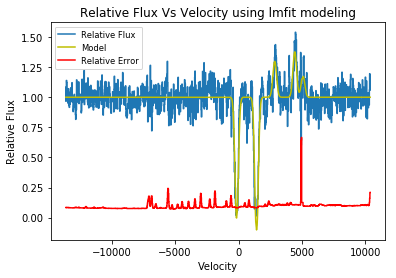

For the MgII lines
[[Model]]
    Model(modelMg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 190
    # data points      = 550
    # variables        = 8
    chi-square         = 13.2987673
    reduced chi-square = 0.02453647
    Akaike info crit   = -2031.23581
    Bayesian info crit = -1996.75647
[[Variables]]
    v1:     -103.097693 +/- 8.53508391 (8.28%) (init = 0)
    v3:      29.7835079 +/- 20.3264731 (68.25%) (init = 130)
    tau1:    1.02307424 +/- 0.01956203 (1.91%) (init = 0.9)
    tau2:    4.80718298 +/- 1.20500636 (25.07%) (init = 1)
    c1:      1.00222269 +/- 0.02169608 (2.16%) (init = 0.8)
    c2:      0.83268353 +/- 0.07363146 (8.84%) (init = 0.7)
    sigma1:  195.027885 +/- 13.3391660 (6.84%) (init = 150)
    sigma2:  121.404363 +/- 10.8891510 (8.97%) (init = 80)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau2, sigma1)   =  0.888
    C(v3, sigma2)     = -0.879
    C(v3, tau2)       = -0.683
    C(c1, c2)         =  0.582

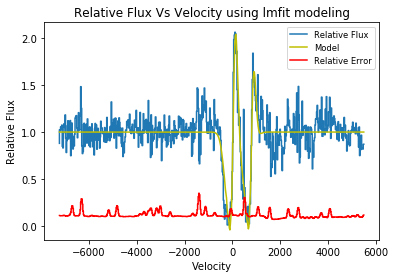

In [25]:
import musetools.modeling as m
import numpy as np
data1 = ascii.read('/home/ahmed/astro/data/rcs0327-knotE-allres-combwC1.txt')
wrest, flx, flx_er = ascii_data(data1,zgal=1.7037455)
print('For the FeII lines')
wrest_Fe, flx_Fe, flx_er_Fe = ascii_spec(wrest, flx, flx_er, 2050, 3130)
#v1=0, tau1=0.7, tau3= 0.4, c1=1.1, c2=1.7,c3=1., sigma1=150, sigma2=100
p0_Fe = [ 0., 0.7, 0.4, 1.1, 1.7, 1., 150., 100.]
flx_norm_Fe, flx_er_norm_Fe, vel_Fe = ascii_contn_vel(wrest_Fe,flx_Fe, flx_er_Fe,2586.650,2580.,2640.)
report_Fe = model_lmfit(m.modelFe,flx_norm_Fe,flx_er_norm_Fe,vel_Fe,p0_Fe,p=True)
print(report_Fe)

print('For the MgII lines')
p0_Mg = [ 0., 130., 0.9, 1., 0.8, 0.7, 150., 80.]
wrestMg, flx_Mg, flx_er_Mg = ascii_spec(wrest, flx, flx_er, 3400, 3950)
flx_norm_Mg, flx_er_norm_Mg, vel_Mg= ascii_contn_vel(wrestMg,flx_Mg,flx_er_Mg,2796.351,2780.,2810.)
#flx_norm_Mg = np.nan_to_num(flx_norm_Mg)
#flx_er_norm_Mg = np.nan_to_num(flx_norm_Mg)
#vel_Mg = np.nan_to_num(vel_Mg)
report_Mg = model_lmfit(m.modelMg,flx_norm_Mg, flx_er_norm_Mg, vel_Mg,p0_Mg,p=True)

[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 350
    # variables        = 8
    chi-square         = 3.07841302
    reduced chi-square = 0.00900121
    Akaike info crit   = -1640.73163
    Bayesian info crit = -1609.86816
[[Variables]]
    v1:     -162.770930 +/- 5.62383836 (3.46%) (init = 0)
    tau1:    1.01324045 +/- 0.06121885 (6.04%) (init = 0.7)
    tau3:    0.36634345 +/- 0.07756550 (21.17%) (init = 0.4)
    c1:      1.13283041 +/- 0.07501130 (6.62%) (init = 1.1)
    c2:      1.42456928 +/- 0.29413735 (20.65%) (init = 1.7)
    c3:      0.48024749 +/- 0.18693780 (38.93%) (init = 1)
    sigma1:  119.522732 +/- 6.87700921 (5.75%) (init = 150)
    sigma2:  84.9371463 +/- 16.3962824 (19.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.655
    C(tau1, c1)     = -0.618
    C(tau3, sigma2) = -0.601
    C(tau1, sigma1) = -0.568
    C(c2, c3)       =  0

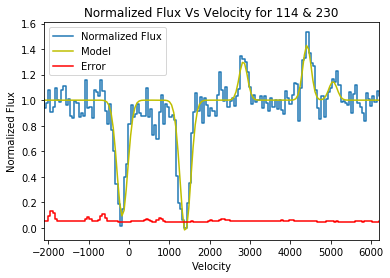

In [7]:
fitsfile = '/home/ahmed/astro/data/RCS0327_16mc_zap.fits'
cx = 114
cy = 230
from musetools import io as io
from musetools import spec as s
import musetools.util as u
import musetools.modeling as m
from astropy.wcs import WCS
from astropy.io import fits
wave, data, var, header = io.open_muse_cube(fitsfile)
w = WCS(header)
zgal= 1.7037455
wrest = wave/(1.+zgal)
spec, spec_err = s.extract_square(cx, cy, wave, data, var, 5)
minindex = 1750
maxindex = 2100
wave = wave[minindex:maxindex]
spec = spec[minindex:maxindex]
spec_err = spec_err[minindex:maxindex]
wrest= wrest[minindex:maxindex]
minw = 6967.
maxw = 7111.   # These are the wavelength limits for Fe lines
q = np.where(( wave > minw) & (wave < maxw))
wrest_fit = np.delete(wrest, q)
spec_fit = np.delete(spec, q)
cont = np.poly1d(np.polyfit(wrest_fit, spec_fit, 3))  # Defining my polynomial
continuum = cont(wrest)
lam_center = [2586.650,2600.173,2612.654,2626.451]
norm_flx = spec/continuum
norm_flx_err = spec_err/continuum
vel1 = u.veldiff(wrest,lam_center[0])

gmodel = Model(m.modelFe)
result = gmodel.fit(norm_flx,v=vel1, v1=0, tau1=0.7, tau3= 0.4, c1=1.1, c2=1.7,c3=1., sigma1=150, sigma2=100)#,sigma3=100,sigma4=95)
print(result.fit_report())

print(result.fit_report())
plt.step(vel1, norm_flx, label='Normalized Flux')
plt.plot(vel1, result.best_fit, 'y-',label='Model')
plt.step(vel1, norm_flx_err,'r',label='Error')
plt.legend(loc=0)
plt.title('Normalized Flux Vs Velocity for '+str(cx)+' & '+str(cy)+'')
plt.xlabel('Velocity')
plt.ylabel('Normalized Flux')
plt.xlim([-2100,6200])
plt.show()

[-164.44223932    1.00952228    0.35759245    1.1327526     1.44536651
    0.48685956  120.73133296   84.81079929]
[[ 2.28732816e+01 -4.05696526e-03  2.50683390e-03  6.31066520e-03
  -9.11184058e-03 -3.83821599e-03  2.42239941e-01  5.18357230e-02]
 [-4.05696526e-03  2.54248747e-03 -4.44629600e-07 -1.98740817e-03
   1.61613980e-06  6.80772844e-07 -1.63755153e-01 -9.19394655e-06]
 [ 2.50683390e-03 -4.44629600e-07  4.93286536e-03  6.91627451e-07
  -1.29451509e-02 -4.35048339e-03  2.65486740e-05 -6.22586647e-01]
 [ 6.31066520e-03 -1.98740817e-03  6.91627451e-07  3.70150330e-03
  -2.51392766e-06 -1.05895151e-06  1.42084925e-03  1.43013101e-05]
 [-9.11184058e-03  1.61613980e-06 -1.29451509e-02 -2.51392766e-06
   7.65412647e-02  1.77524698e-02 -9.64991279e-05 -3.44045113e-02]
 [-3.83821599e-03  6.80772844e-07 -4.35048339e-03 -1.05895151e-06
   1.77524698e-02  2.87657029e-02 -4.06487024e-05 -1.53255956e-02]
 [ 2.42239941e-01 -1.63755153e-01  2.65486740e-05  1.42084925e-03
  -9.64991279e-05 -4.

(-2100, 6200)

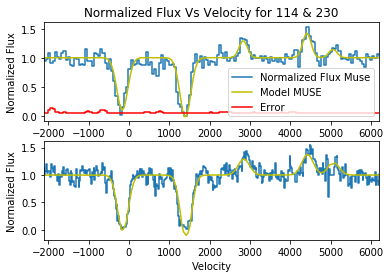

In [35]:
def model_curve_fit(func, vel, flx_norm, p0,flx_er_norm):
    # p0 is the initial parameters
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func, vel, flx_norm,p0,sigma=flx_er_norm)
    print(popt)
    print(pcov)
    return popt, pcov
p0 = [0.,0.7,0.4,1.1,1.7,1.,150.,100.]
popt_muse, pcov_muse = model_curve_fit(m.modelFe, vel1, norm_flx,p0,norm_flx_err )
#m.modelFe,flx_norm_Fe,flx_er_norm_Fe,vel_Fe,p0_Fe,p=True
popt_magE, pcov_magE = model_curve_fit(m.modelFe, vel_Fe, flx_norm_Fe, p0, flx_er_norm_Fe)
fig, ax = plt.subplots(2)
ax[0].step(vel1, norm_flx, label='Normalized Flux Muse')
ax[0].plot(vel1, m.modelFe(vel1,*popt_muse), 'y-',label='Model MUSE')
ax[0].step(vel1, norm_flx_err,'r',label='Error')
ax[0].legend(loc=0)
ax[0].set_title('Normalized Flux Vs Velocity for '+str(cx)+' & '+str(cy)+'')
ax[0].set_xlabel('Velocity')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_xlim([-2100,6200])
ax[1].step(vel_Fe, flx_norm_Fe, label='Normalized Flux MagE')
ax[1].plot(vel_Fe, m.modelFe(vel_Fe,*popt_magE),'y-',label='Model MagE')
ax[1].set_xlabel('Velocity')
ax[1].set_ylabel('Normalized Flux')
ax[1].set_xlim([-2100,6200])



In [4]:
### WE will do the same for knot U

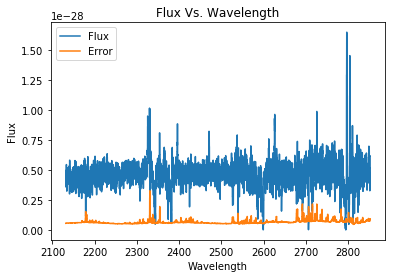

For the FeII lines:


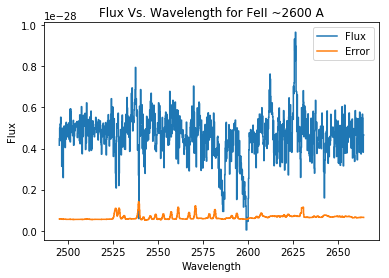

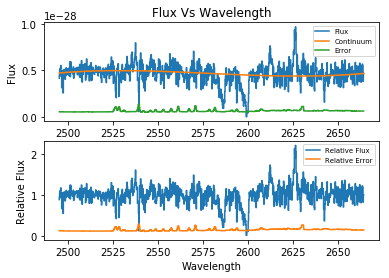

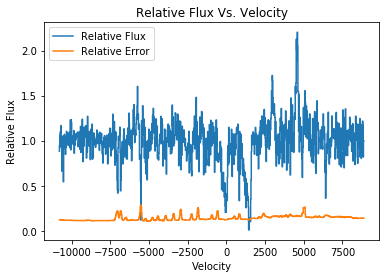

[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 227
    # data points      = 890
    # variables        = 8
    chi-square         = 28.2589082
    reduced chi-square = 0.03203958
    Akaike info crit   = -3054.33332
    Bayesian info crit = -3016.00355
[[Variables]]
    v1:     -35.0649597 +/- 6.71524543 (19.15%) (init = 0)
    tau1:    0.57177272 +/- 0.05704251 (9.98%) (init = 0.7)
    tau3:    0.66213656 +/- 0.10155183 (15.34%) (init = 0.4)
    c1:      1.06695861 +/- 0.12528745 (11.74%) (init = 1.1)
    c2:      1.82539888 +/- 0.26027426 (14.26%) (init = 1.7)
    c3:      0.61249977 +/- 0.14641117 (23.90%) (init = 1)
    sigma1:  201.485169 +/- 17.4636667 (8.67%) (init = 150)
    sigma2:  71.9369386 +/- 9.31279390 (12.95%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.717
    C(tau1, c1)     = -0.597
    C(tau3, sigma2) = -0.578
    C(tau1, sigma1) = -0.532
    C(c2, c3)       =

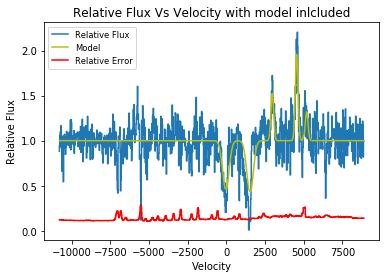

For the MgII lines:


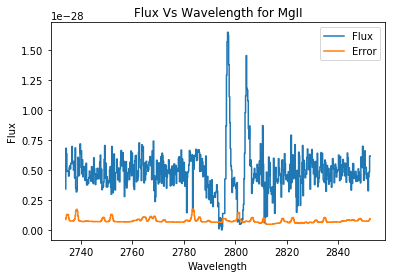

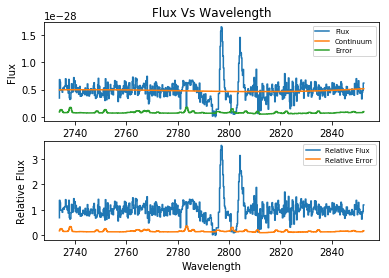

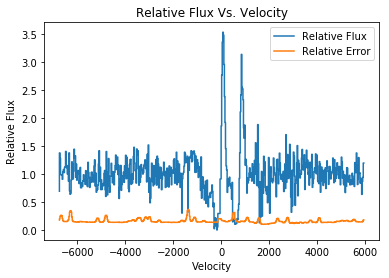

[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 1080
    # variables        = 8
    chi-square         = 10.7451997
    reduced chi-square = 0.01002351
    Akaike info crit   = -4963.07778
    Bayesian info crit = -4923.20005
[[Variables]]
    v1:     -146.438632 +/- 3.72091183 (2.54%) (init = 0)
    tau1:    1.17945371 +/- 0.05040697 (4.27%) (init = 0.7)
    tau3:    0.32317490 +/- 0.03595026 (11.12%) (init = 0.4)
    c1:      1.19941960 +/- 0.05711671 (4.76%) (init = 1.1)
    c2:      1.26654253 +/- 0.15811277 (12.48%) (init = 1.7)
    c3:      0.61767344 +/- 0.13584302 (21.99%) (init = 1)
    sigma1:  116.950865 +/- 4.54618012 (3.89%) (init = 150)
    sigma2:  132.288161 +/- 12.0659119 (9.12%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.689
    C(tau1, sigma1) = -0.646
    C(tau3, sigma2) = -0.471
    C(tau1, c1)     = -0.397
    C(c2, c3)       =  0

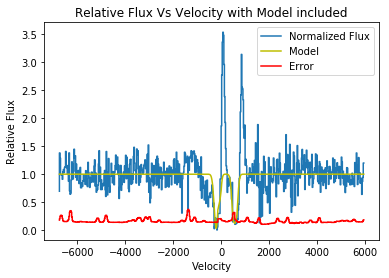

In [80]:
data2 = ascii.read('/home/ahmed/astro/data/rcs0327-knotU-tel-combwC1.txt')
# This is my own directory
wrest, flux, noise=ascii_data(data2)
'''
minFeindex = 2150
maxFeindex = 3040
'''
print('For the FeII lines:')
wrestFe, fluxFe, noiseFe=Fe_spec(wrest, flux, noise, 2150, 3040)
fluxFe_norm, noiseFe_norm, vel_Fe = contn_velFe(wrestFe,fluxFe,noiseFe,2575.,2650.)
model_Fe(fluxFe_norm,noiseFe_norm,vel_Fe)
print('For the MgII lines:')
wrestMg, fluxMg, noiseMg = Mg_spec(wrest, flux, noise, 3400, 3950)
fluxMg_norm, noiseMg_norm, vel_Mg=contn_velMg(wrestMg,fluxMg,noiseMg,2780.,2810.)
model_Mg(fluxMg_norm, noiseMg_norm, vel_Mg)

In [89]:
### For Knot G:

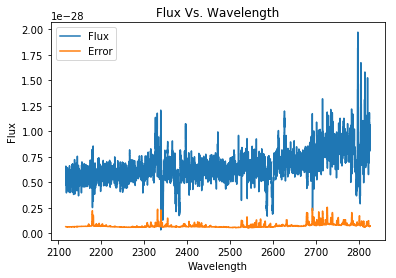

For the FeII lines:


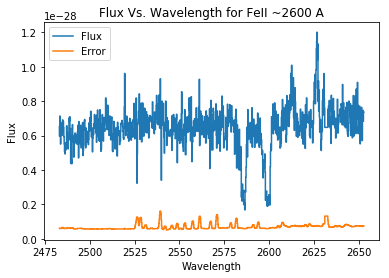

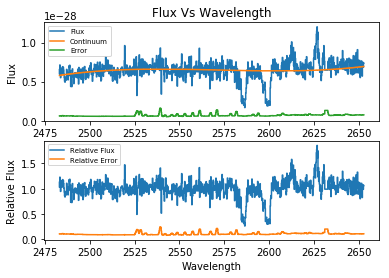

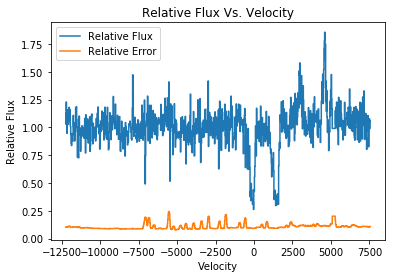

[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 190
    # data points      = 890
    # variables        = 8
    chi-square         = 14.4222285
    reduced chi-square = 0.01635173
    Akaike info crit   = -3652.98121
    Bayesian info crit = -3614.65144
[[Variables]]
    v1:     -94.2339806 +/- 7.19050772 (7.63%) (init = 0)
    tau1:    0.73294672 +/- 0.04650572 (6.35%) (init = 0.7)
    tau3:    0.32404349 +/- 0.03933366 (12.14%) (init = 0.4)
    c1:      1.02944330 +/- 0.07646616 (7.43%) (init = 1.1)
    c2:      1.32917299 +/- 0.18307149 (13.77%) (init = 1.7)
    c3:      0.69826086 +/- 0.18258151 (26.15%) (init = 1)
    sigma1:  141.980496 +/- 8.59855932 (6.06%) (init = 150)
    sigma2:  165.746702 +/- 15.3868297 (9.28%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.714
    C(tau1, c1)     = -0.604
    C(tau1, sigma1) = -0.541
    C(tau3, sigma2) = -0.421
    C(c2, c3)       =  0

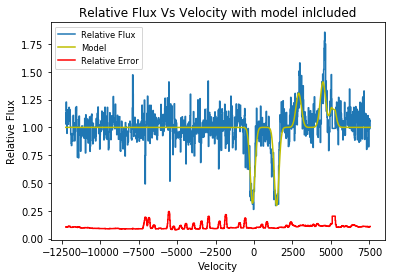

For the MgII lines:


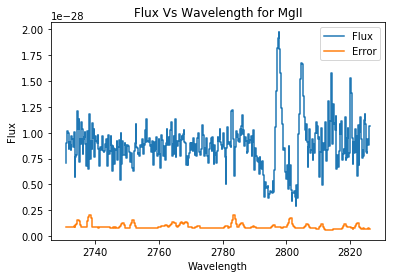

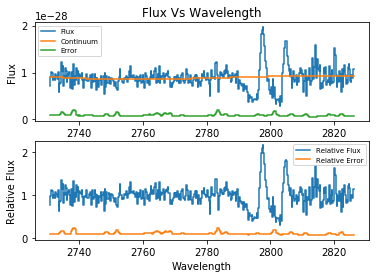

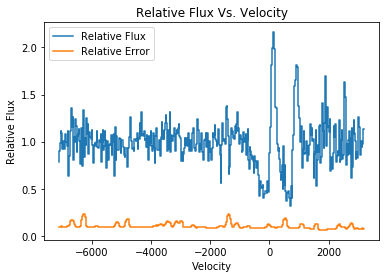

[[Model]]
    Model(modelFe)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 1080
    # variables        = 8
    chi-square         = 10.7451997
    reduced chi-square = 0.01002351
    Akaike info crit   = -4963.07778
    Bayesian info crit = -4923.20005
[[Variables]]
    v1:     -146.438632 +/- 3.72091183 (2.54%) (init = 0)
    tau1:    1.17945371 +/- 0.05040697 (4.27%) (init = 0.7)
    tau3:    0.32317490 +/- 0.03595026 (11.12%) (init = 0.4)
    c1:      1.19941960 +/- 0.05711671 (4.76%) (init = 1.1)
    c2:      1.26654253 +/- 0.15811277 (12.48%) (init = 1.7)
    c3:      0.61767344 +/- 0.13584302 (21.99%) (init = 1)
    sigma1:  116.950865 +/- 4.54618012 (3.89%) (init = 150)
    sigma2:  132.288161 +/- 12.0659119 (9.12%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau3, c2)     = -0.689
    C(tau1, sigma1) = -0.646
    C(tau3, sigma2) = -0.471
    C(tau1, c1)     = -0.397
    C(c2, c3)       =  0

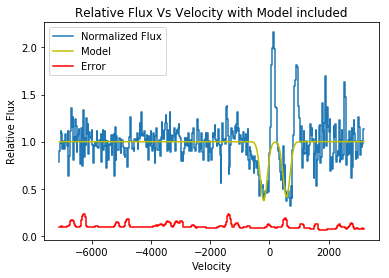

In [88]:
data3 = ascii.read('/home/ahmed/astro/data/rcs0327-knotG-tel-combwC1.txt')
# This is my own directory
wrest, flux, noise=ascii_data(data3)

print('For the FeII lines:')
wrestFe, fluxFe, noiseFe=Fe_spec(wrest, flux, noise, 2200, 3090)
fluxFe_norm, noiseFe_norm, vel_Fe = contn_velFe(wrestFe,fluxFe,noiseFe,2575.,2650.)
model_Fe(fluxFe_norm,noiseFe_norm,vel_Fe)
print('For the MgII lines:')
wrestMg, fluxMg, noiseMg = Mg_spec(wrest, flux, noise, 3500, 3950)
fluxMg_norm, noiseMg_norm, vel_Mg=contn_velMg(wrestMg,fluxMg,noiseMg,2780.,2810.)
model_Mg(fluxMg_norm, noiseMg_norm, vel_Mg)

In [3]:
'''
def Mg_spec(wrest, flx, flx_er, minMgindex, maxMgindex,plot=False):
    #minMgindex = 3400
    #maxMgindex = 3950
    wrestMg = wrest[minMgindex:maxMgindex]
    flxMg  = flux[minMgindex:maxMgindex]
    flx_er_Mg = noise[minMgindex:maxMgindex]
    if plot=True:
        fig1, ax1 = plt.subplots()
        ax1.step(wrestMg,flxMg,label='Flux')
        ax1.step(wrestMg,flx_er_Mg,label='Error')
        ax1.legend(loc=0)
        ax1.set_xlabel('Wavelength')
        ax1.set_ylabel('Flux')
        ax1.set_title('Flux Vs Wavelength for MgII')
        plt.show()
    return wrestMg, flxMg, flx_er_Mg
'''
'''
def contn_velMg(wrest,flux, noise,wmin,wmax):
    #wmin = 2580.
    #wmax = 2640.
    f = np.where((wrest > wmin) & (wrest < wmax))
    wrest_fit = np.delete(wrest, f)
    flux_fit = np.delete(flux,f)
    cont = np.poly1d(np.polyfit(wrest_fit, flux_fit, 3))
    continuum = cont(wrest)
    flux_norm = flux/continuum
    noise_norm = noise/continuum
    
    fig1, ax1 = plt.subplots(2)
    ax1[0].step(wrest,flux,label='Flux')
    ax1[0].step(wrest,continuum,label='Continuum')
    ax1[0].step(wrest,noise,label='Error')
    ax1[0].legend(loc=0,fontsize='x-small')
    ax1[0].set_xlabel('Wavelength')
    ax1[0].set_ylabel('Flux')
    ax1[0].set_title('Flux Vs Wavelength')
    
    ax1[1].step(wrest,flux_norm,label='Relative Flux')
    ax1[1].step(wrest,noise_norm,label='Relative Error')
    ax1[1].legend(loc=0,fontsize='x-small')
    ax1[1].set_xlabel('Wavelength')
    ax1[1].set_ylabel('Relative Flux')
    plt.show()
    import musetools.util as u
    
    vel = u.veldiff(wrest,lam_center[0])
    fig2, ax2 = plt.subplots()
    ax2.step(vel,flux_norm,label='Relative Flux')
    ax2.step(vel,noise_norm,label='Relative Error')
    ax2.legend(loc=0)
    ax2.set_xlabel('Velocity')
    ax2.set_ylabel('Relative Flux')
    ax2.set_title('Relative Flux Vs. Velocity')
    plt.show()
    return flux_norm, noise_norm, vel

def model_Mg(fluxMg_norm, noiseMg_norm,vel_Mg):
    gmodelMg = Model(m.modelMg)
    result2 = gmodelMg.fit(fluxMg_norm,v=vel_Mg,)
    print(result.fit_report())
    fig4, ax4 = plt.subplots()
    ax4.step(vel_Mg, fluxMg_norm, label='Normalized Flux')
    ax4.plot(vel_Mg, result2.best_fit, 'y-', label='Model')
    ax4.step(vel_Mg, noiseMg_norm,'r',label='Error')
    ax4.legend(loc=0)
    ax4.set_title('Relative Flux Vs Velocity with Model included')
    ax4.set_xlabel('Velocity')
    ax4.set_ylabel('Relative Flux')
    plt.show()
    return
'''

"\ndef contn_velMg(wrest,flux, noise,wmin,wmax):\n    #wmin = 2580.\n    #wmax = 2640.\n    f = np.where((wrest > wmin) & (wrest < wmax))\n    wrest_fit = np.delete(wrest, f)\n    flux_fit = np.delete(flux,f)\n    cont = np.poly1d(np.polyfit(wrest_fit, flux_fit, 3))\n    continuum = cont(wrest)\n    flux_norm = flux/continuum\n    noise_norm = noise/continuum\n    \n    fig1, ax1 = plt.subplots(2)\n    ax1[0].step(wrest,flux,label='Flux')\n    ax1[0].step(wrest,continuum,label='Continuum')\n    ax1[0].step(wrest,noise,label='Error')\n    ax1[0].legend(loc=0,fontsize='x-small')\n    ax1[0].set_xlabel('Wavelength')\n    ax1[0].set_ylabel('Flux')\n    ax1[0].set_title('Flux Vs Wavelength')\n    \n    ax1[1].step(wrest,flux_norm,label='Relative Flux')\n    ax1[1].step(wrest,noise_norm,label='Relative Error')\n    ax1[1].legend(loc=0,fontsize='x-small')\n    ax1[1].set_xlabel('Wavelength')\n    ax1[1].set_ylabel('Relative Flux')\n    plt.show()\n    import musetools.util as u\n    \n    vel